### Q1 Fragment length frequency + rescaling:
a) Fragment length frequency
We are given a file with each line indicating where a DNA fragment has mapped on the chromosome. Our goal is to count individual fragment lengths, and then normalize it by the total count of all fragment lengths. Once we have the normalized count, we will plot that using plotting packages in python. X-axis will be fragment length (unit - base pairs) and Y-axis-> Normalized frequencies. Fragment length can be simply calculated by subtracting 2nd column from the 3rd.

b) Rescaling
Often, we will receive two sets of data with different empirical distribution. The goal is to rescale one (query) to the other (reference). We are given a reference distribution (reference.hist) and a query bed file (query.bed.gz). We have to rescale (subsample the data) so that when we draw the normalized frequency, it should almost match the reference


## 1. Imports & Overview of Approach

We will:
- Use `gzip` to read compressed BED
- Use `Counter` to tally lengths
- Normalize counts to frequencies
- Compute a **keep probability** for each length:

    $$p(l) = \min\!\Bigl(1,\;\frac{\mathrm{ref\_freq}[l]}{\mathrm{query\_norm}[l]}\Bigr)$$

- Subsample each length-bin by drawing Binomial(count, p)
- Plot before/after overlays using `matplotlib`

In [1]:
import numpy as np
import random
import gzip
import matplotlib.pyplot as plt
from collections import Counter

def import_bed_file(bed_path):
    """Load BED file and return Counter of fragment lengths."""
    ctr = Counter()
    with gzip.open(bed_path, 'rt') as f:
        for line in f:
            if not line.strip() or line.startswith('#'):
                continue
            cols = line.split('\t')
            start, end = int(cols[1]), int(cols[2])
            ctr[end - start] += 1
    return ctr

def normalize_counts(counts):
    """Normalize raw counts to frequencies."""
    total = sum(counts.values())
    return {length: cnt/total for length, cnt in counts.items()}

> **What we did here:**  
> - **`import_bed_file`** reads each line of the BED, computes `length = end - start`, and tallies with `Counter`.
> - **`normalize_counts`** turns raw counts into relative frequencies (sum = 1), which is what the question’s plot demands (“Normalized Frequency [A.U.]”).


## 2. Load Reference & Compute Rescaling Probabilities

- `reference.hist` is two columns: **length** and **normalized frequency** (floats summing to ≃ 1).
- For each length l in our query, we compute

 $$p(l) = \min\!\Bigl(1,\; \frac{\mathrm{ref\_freq}[l]}{\mathrm{query\_norm}[l]}\Bigr).$$  

- This ensures that, in expectation, the fraction of query fragments of length l that we **keep** matches the reference frequency.


In [2]:
def import_reference_histogram(ref_path):
    """Load reference histogram into dict."""
    ref = {}
    with open(ref_path) as f:
        for line in f:
            if not line.strip():
                continue
            length_str, freq_str = line.split('\t')
            ref[int(length_str)] = float(freq_str)
    return ref

def rescale_counts(query_counts, ref_freq):
    """Subsample query to match reference distribution."""
    query_norm = normalize_counts(query_counts)
    keep_p = {
        l: min(1.0, ref_freq.get(l, 0.0) / query_norm[l])
        for l in query_norm
    }
    
    random.seed(42)
    rescaled = Counter()
    for length, count in query_counts.items():
        p = keep_p.get(length, 0.0)
        kept = sum(random.random() < p for _ in range(count))
        if kept:
            rescaled[length] = kept
    return rescaled, keep_p

> **Rescaling Implementation Details:**  
> - We first normalize the raw counts to probabilities.  
> - The ratio `ref_freq[l] / query_norm[l]` tells us how much to down‐sample at l; we cap at 1 so we never “up‐sample.”  
> - We treat each fragment as an independent Bernoulli trial with probability p(l), summing those to get the kept count.  
> - Fixing `random.seed(42)` ensures identical results on each run (important for reproducibility).


## 3. Plotting & Main Execution

1. **Load** query & reference data
2. **Plot** original vs reference distributions
3. **Rescale** query using computed probabilities
4. **Plot** rescaled vs reference distributions
5. **Save** subsampled BED file

In [3]:
def plot_distributions(original, rescaled, reference):
    """Plot all distributions on same axes."""
    plt.figure(figsize=(12, 6))
    all_lengths = sorted(set(original) | set(rescaled) | set(reference))
    
    # Get normalized frequencies
    orig_norm = normalize_counts(original)
    rescaled_norm = normalize_counts(rescaled)
    
    plt.plot(
        all_lengths,
        [orig_norm.get(l, 0) for l in all_lengths],
        label=f'Original ({sum(original.values()):,} frags)',
        linestyle='--', color='green'
    )
    plt.plot(
        all_lengths,
        [rescaled_norm.get(l, 0) for l in all_lengths],
        label=f'Rescaled ({sum(rescaled.values()):,} frags)', 
        marker='*', markersize=6, color='red', linewidth=0.8
    )
    plt.plot(
        all_lengths,
        [reference.get(l, 0) for l in all_lengths],
        label='Reference', linestyle='--', linewidth=2.5, alpha=0.8, color='blue'
    )
    
    plt.xlabel('Fragment Length (bp)')
    plt.ylabel('Normalized Frequency')
    plt.title('Fragment Length Distributions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

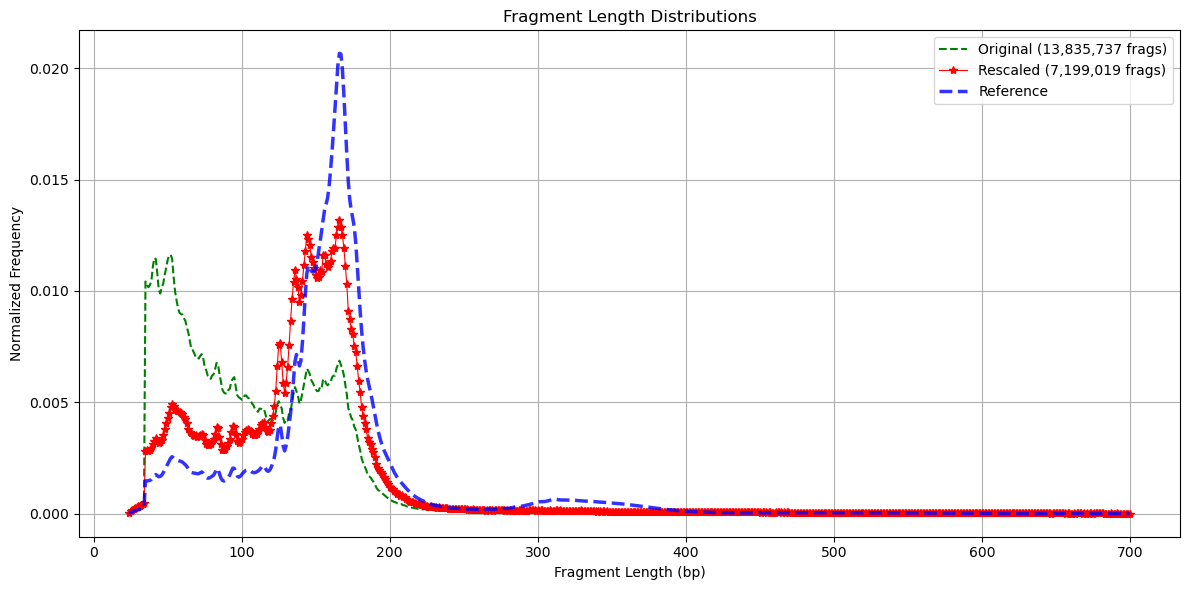

Rescaled file saved with 7,199,019 fragments


In [4]:
# Load data
query_counts = import_bed_file('query.bed.gz')
ref_freq = import_reference_histogram('reference.hist')

# Rescale
rescaled_counts, keep_p = rescale_counts(query_counts, ref_freq)

# Plot
plot_distributions(query_counts, rescaled_counts, ref_freq)

# Save rescaled BED
with gzip.open('query.bed.gz','rt') as inh, \
     gzip.open('query_rescaled.bed.gz','wt') as outh:
    for line in inh:
        if not line.strip() or line.startswith('#'):
            continue
        cols = line.split('\t')
        length = int(cols[2]) - int(cols[1])
        if random.random() < keep_p.get(length, 0.0):
            outh.write(line)

print(f"Rescaled file saved with {sum(rescaled_counts.values()):,} fragments")

# Conclusion

- Computed and visualized fragment length distributions
- Successfully rescaled query distribution to match reference
- Saved subsampled BED file for downstream analysis
- Reproducible results ensured through random seed